In [4]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import array
from multiprocessing import Pool
from edgelist_methods import *
from itertools import product
from par_funcs import *
%matplotlib inline
sys.path.append('..')

# -------------------------------- parameters ---------------------------------------
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
# pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'

out_folder = '/nobackup/turaga/singhc/par_zwshed/' # _3k _vol has full, max_len = 300
outname = out_folder+'out.h5'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack( ((0, 0, 0), np.random.rand(1e6, 3))) )
NUM_WORKERS = 32
MAX_LEN = 100
V = 20

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Divide Volumes, set up args

In [5]:
args,starts,ends,dims,num_vols = partition_subvols(pred_file,out_folder,max_len=MAX_LEN)

dims [ 200 3072 3072]
num_vols [ 3 31 31]
deltas [66 99 99]


# Call Watershed

In [104]:
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args[0:2])

finished /nobackup/turaga/singhc/par_zwshed/0_0_96_vol/ watershed
finished /nobackup/turaga/singhc/par_zwshed/0_0_0_vol/ watershed


[None, None]

# Stitch

i,x,y,z 0 0 0 0
i,x,y,z 1 0 0 1
filter_merges...


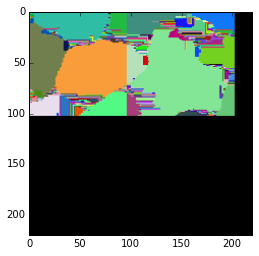

merge


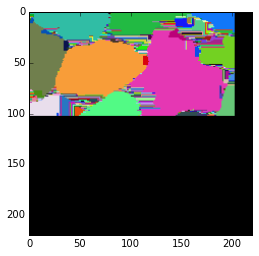

calculating seg_sizes all...


In [8]:
def stitch_and_save(args,starts,ends,dims,num_vols,outname,(X,Y,Z)=num_vols):
    if op.isfile(outname):
        os.remove(outname)
    f = h5py.File(outname, 'a')
#     dset_seg = f.create_dataset('seg', dims, dtype='uint64', chunks=True)
    dset_seg = f.create_dataset('seg', (110,220,220), dtype='uint64', chunks=True)
    inc,re,merges,rgs,i_arr=0,{},{},{},[]

    # calc all merges, set dset_seg, rg with incrementing
    for x,y,z in product(range(X),range(Y),range(Z)):
        i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
        i_arr.append(i)
        s,e = starts[i],ends[i]
        basic_file = h5py.File(args[i][-1]+'basic.h5','r')
        seg,rg = np.array(basic_file['seg']),np.array(basic_file['rg'])
        seg[seg!=0]+=inc
        rg[:,:2] += inc
        rgs[i] = rg
        inc = np.max(seg)
        print "i,x,y,z",i,x,y,z
        if not z==0: 
            re,merges = calc_merges(edge_mins=dset_seg[s[0]:e[0],s[1]:e[1],s[2]+3],edge_maxes=seg[:,:,3], re=re, merges=merges)
        if not y==0:
            re,merges = calc_merges(edge_mins=dset_seg[s[0]:e[0],s[1]+3,s[2]:e[2]],edge_maxes=seg[:,3,:],re=re,merges=merges)
        if not x==0:
            re,merges = calc_merges(edge_mins=dset_seg[s[0]+3,s[1]:e[1],s[2]:e[2]],edge_maxes=seg[3,:,:],re=re, merges=merges)
        dset_seg[s[0]:e[0],s[1]:e[1],s[2]:e[2]] = seg[:,:,:]
#         plt.imshow(dset_seg[0, :, :], cmap=cmap)
#         plt.show()
    
    merges_filtered = filter_merges(merges)
    plt.imshow(dset_seg[V, :, :], cmap=cmap)
    plt.show()
    
    rgs = merge(merges_filtered,rgs,i_arr,args,f,max_val=inc)
    
    plt.imshow(dset_seg[V, :, :], cmap=cmap)
    plt.show()
    
    seg_sizes = calc_seg_sizes(f)

    # save
    f = h5py.File(outname, 'a')
    dset_seg_sizes = f.create_dataset('seg_sizes', data=np.array(seg_sizes))
    for key in rgs:
        rg_dset = f.create_dataset('rg_'+str(key),data=np.array(rgs[key]))
    dset_starts = f.create_dataset('starts',data=np.array(starts))
    dset_ends = f.create_dataset('ends',data=np.array(ends))                               
    f.close()
X,Y,Z = (1,1,2)#num_vols# (1,2,2)
stitch_and_save(args,starts,ends,dims,num_vols,outname,(X,Y,Z))

# Agglomeration

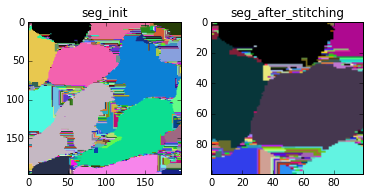

num_segs 108910 20775
rg lens 543722 112439
calculating renums...

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in uint_scalars



filtering renums...
renumbering...
calculating renums...
filtering renums...
renumbering...


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


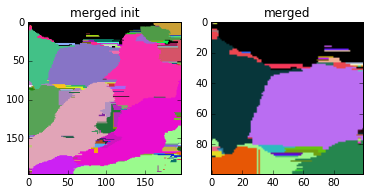

num_segs 108910 20775
rg lens 543722 112439


In [109]:
def merge_by_thresh(seg,seg_sizes,rg,thresh):
    re = {}
    seg_max = np.max(seg)
    seg_min = np.min(seg)
    print "calculating renums..."
    for i in range(rg.shape[0]):
        n1,n2,w = rg[i,:]
        size = w*w*thresh
        if seg_sizes[n1] < size or seg_sizes[n2] < size:
            re[n2]=n1
            seg_sizes[n1]+=seg_sizes[n2]
            seg_sizes[n2]+=seg_sizes[n1]
    re_filtered = {}
    print "filtering renums..."
    for key in re:
        val = re[key]
        while val in re:
            val = re[val]
        if key < seg_max and val < seg_max:
            re_filtered[key] = val
    
    print "renumbering..."
    mp = np.arange(0,seg_max+1,dtype='uint64')
    mp[re_filtered.keys()] = re_filtered.values()
    seg = mp[seg]
    return seg

num,thresh = 0,2000

plt.subplot(1,2,1)
basic_file = h5py.File('/nobackup/turaga/singhc/par_zwshed/0_0_0_voll/'+'basic.h5','r')
seg_init = np.array(basic_file['seg'])
rg_init = np.array(basic_file['rg'])
keeps = rg_init[:,0]<rg_init[:,1]
rg_init = rg_init[keeps,:]

seg_sizes_init = np.array(basic_file['counts'])
basic_file.close()
plt.imshow(seg_init[V,:,:], cmap=cmap)
plt.title('seg_init')

plt.subplot(1,2,2)
f = h5py.File(outname, 'a')
s,e = f['starts'][num],f['ends'][num]
seg = f['seg'][s[0]:e[0]-3,s[1]:e[1]-3,s[2]:e[2]-3]
seg_sizes = np.array(f['seg_sizes'])
rg = np.array(f['rg_'+str(num)])
f.close()
plt.imshow(seg[V,:,:], cmap=cmap)
plt.title('seg_after_stitching')
plt.show()

print "num_segs",len(np.unique(seg_init)),len(np.unique(seg))
print "rg lens",len(rg_init),len(rg)


seg_init_merged = merge_by_thresh(seg_init,seg_sizes_init,rg_init,thresh)
seg_merged = merge_by_thresh(seg,seg_sizes,rg,thresh)

plt.subplot(1,2,1)
plt.imshow(seg_init_merged[V,:,:], cmap=cmap)
plt.title('merged init')
plt.subplot(1,2,2)
plt.imshow(seg_merged[V,:,:], cmap=cmap)
plt.title('merged')
plt.show()

print "num_segs",len(np.unique(seg_init)),len(np.unique(seg))
print "rg lens",len(rg_init),len(rg)

In [86]:
'''
basic_file = h5py.File(args[num][-1]+'basic.h5','r')
seg_init = np.array(basic_file['seg'])
rg_init = np.array(basic_file['rg'])
keeps = rg_init[:,0]<rg_init[:,1]
rg_init = rg_init[keeps,:]

seg_sizes_init = np.array(basic_file['counts'])
basic_file.close()
'''

f = h5py.File(outname, 'a')
s,e = f['starts'][num],f['ends'][num]
seg = np.array(f['seg'])
f.close()

si = seg_init.ravel()
s = seg.ravel()
print "min s",np.min(s)
print "rg lens",len(rg_init),len(rg)
for i in range(10):
    print "init ",str(i),":",np.sum(si==i),seg_sizes_init[i],'\t',np.sum(s==i),seg_sizes[i]
x = np.unique(s)
print x[0:20]

min s 0
rg lens 113550 112439
init  0 : 0 0 	3867580 3867580
init  1 : 4 4 	4 4
init  2 : 21710 21710 	36994 36994
init  3 : 13 13 	13 13
init  4 : 15 15 	15 15
init  5 : 22710 22710 	29471 29471
init  6 : 2 2 	2 2
init  7 : 2 2 	2 2
init  8 : 3787 3787 	3787 3787
init  9 : 17443 17443 	17450 17450
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


# Visualize

In [7]:
import nyroglancer

seg = np.arange(0,10000)
seg = np.reshape(seg,(100,100))
seg = np.array(seg,dtype='uint32')

v = nyroglancer.Viewer()
v.set_hostname("localhost:8000")
v.put(seg, resolution=[1,1,1], vtype="segmentation", name="raw")
v.show()